Below is a “cook-book” style plan showing how you can reproduce Figure 2 a of Thiemann et al. (2017) with Python and scikit-learn.
Everything is written as a sequence of clearly separated steps so that you can translate it almost literally into code (Jupyter, PyCharm, …).
Only standard scientific-Python packages are needed: numpy, scikit-learn, scipy, matplotlib.

────────────────────────────────────────────────────────────────────────
0.  FOLDER STRUCTURE AND REPRODUCIBILITY
────────────────────────────────────────────────────────────────────────
│ ionosphere_demo/
│   ├── data/                # raw ionosphere.data from UCI
│   ├── iono_experiment.py   # your main script / notebook
│   └── utils.py             # helper routines (optional)

• Fix the random seed at the beginning of every run (np.random.seed, random.seed).
• Use float64 everywhere (numpy default).

────────────────────────────────────────────────────────────────────────

DATA PREPARATION  (IONOSPHERE)
────────────────────────────────────────────────────────────────────────
1.1  Download “ionosphere.data” from UCI ML repository.
1.2  Convert the “g / b” label to {+1, –1}.
1.3  z-score each column (StandardScaler in scikit-learn).
1.4  Split as in the paper (Table 1):

n      = 200   (training set S)
n_test = 150   (test set T)

Randomly shuffle the 350 available points, take the first 200 for S
and the remaining 150 for T.  Store the permutation so the same split
is used for all values of m.

────────────────────────────────────────────────────────────────────────
2.  REFERENCE (STRONG) SVM TUNED BY 5-FOLD CV
────────────────────────────────────────────────────────────────────────
2.1  Grid for C          : 10^{-3,…,+3}
2.2  Grid for γ (RBF)    : Jaakkola heuristic as in the paper
• Compute G_i = min_{j: y_j≠y_i} ‖x_i – x_j‖.
• γ_J = 1 / (2 median(G)^2).
• grid = γ_J · 10^{–4, –2, 0, +2, +4}.

2.3  sklearn.model_selection.GridSearchCV with
SVC(kernel='rbf', probability=False, cache_size=500, shrinking=True).

2.4  Fit on the 200 training points, keep the best estimator, call it “CV-SVM”.
2.5  Evaluate zero-one loss on the 150 test points → L_CV (≈ 0.06 in the paper).

────────────────────────────────────────────────────────────────────────
3.  BUILD THE FINITE HYPOTHESIS SET  H
────────────────────────────────────────────────────────────────────────
Fixed constants for Fig. 2 a:

d  = 34                        # number of features after preprocessing  
r  = d + 1 = 35                # size of each weak-SVM training subset  
m  ∈ {1, 2, 4, 8, 16, 32, 64, 128}   # values along the x-axis in Fig. 2 a  
For each value of m do:

3.1  Loop j = 1 … m
• Draw a subset S_j (size r) without replacement from the 200 training
indices.
• Validation set V_j = S \ S_j  (size n–r = 165).
• Choose γ_j uniformly at random from the γ-grid defined in step 2.
• Fix C = 1  (paper reports that the margin parameter has little influence
for such tiny training sets).
• Train an SVC on (X[S_j], y[S_j]) with kernel='rbf', C=1, gamma=γ_j.
• Store the fitted SVM, its training indices S_j and γ_j.

3.2  After the loop you have m trained weak classifiers h_1,…,h_m.

────────────────────────────────────────────────────────────────────────
4.  COLLECT VALIDATION LOSSES  L̂_val(h_j)
────────────────────────────────────────────────────────────────────────
For each weak SVM h_j:

L̂_val(h_j) =  (# misclassified points in V_j) / |V_j|   ∈ [0,1].
Store the vector L̂ = (L̂_1,…,L̂_m) and also n_val = n – r = 165 (will be needed).

────────────────────────────────────────────────────────────────────────
5.  MINIMISE THE PAC-BAYES-λ BOUND
────────────────────────────────────────────────────────────────────────
Notation reminder (Section 3 in the paper, with the “finite H” constants):

π(h) = 1/m                   (uniform prior)  
δ    = 0.05                   (fixed)  
n    = n_val = 165           (validation set size)  
L̂    = vector of validation losses  
Alternating minimisation loop
———————————————
Initialise
ρ^{(0)} = (1/m,…,1/m),     λ^{(0)} = 0.5.
Repeat until convergence (≤ 1e-6 relative change or ≤20 iterations):

(1) ρ-update    (use Eq. (7))
ρ_i ∝ π_i · exp( – λ n L̂_i )        → normalise

    KL = Σ ρ_i log(m ρ_i)                # because π_i = 1/m
(2) λ-update    (use Eq. (8))
A = Σ ρ_i L̂_i                       # empirical risk under ρ
B = KL + ln( 2 √n / δ )              # helper
λ  =  2 / ( √( 2 n A / B ) + 1 )    # equivalent to Eq. (8)

    Clip λ to ( √( ln(2√n/δ) / n ) , 1.0 ) for numerical safety.
Return final ρ, λ.

Compute the value of the PAC-Bayes-λ bound (Eq. (13)) and keep it for plotting.

────────────────────────────────────────────────────────────────────────
6.  PREDICTION ON THE HELD-OUT TEST SET (150 points)
────────────────────────────────────────────────────────────────────────
Two variants:

6.1  Randomised classifier (optional)
Sample one weak SVM from ρ for every test point.

6.2  ρ-WEIGHTED MAJORITY VOTE (what Figure 2 uses)
For each test point x:
logit = Σ_{j=1}^m ρ_j · sign( h_j(x) )
ŷ = +1   if logit > 0   else –1
Loss_MV = (# errors) / 150.

6.3  Record the time spent in:
• generating all subsets + training all weak SVMs
• alternating minimisation
(Use Python’s time.perf_counter())

────────────────────────────────────────────────────────────────────────
7.  PLOT FIGURE 2 a
────────────────────────────────────────────────────────────────────────
Create four 1-D curves (parameterised by m):

•  “Our Method”    : test loss of majority vote  
•  “Bound”         : PAC-Bayes-kl bound on E_ρ[L(h)] (see below)  
•  “CV SVM”        : constant horizontal line = L_CV  
•  time curves     : t_m (PAC-Bayes pipeline) and t_CV (cross-validation)  
PAC-Bayes-kl bound
Use Theorem 2 with n = n_val, replace empirical loss E_ρ[L̂] by A.
Numerically invert kl(a || ·) with bisection (scipy.optimize.brentq).
The result BOUND(m) is deterministic once ρ and A are known.

Axes and style
x-axis: m (log scale 10^0 … 10^2 in figure)
left y-axis: test loss curves
right y-axis: running times (secondary axis)

Matplotlib convenience:

fig, ax1 = plt.subplots()  
ax2 = ax1.twinx()  
ax1.plot(m_vals, loss_PB, 'k', label='Our Method')  
…  
────────────────────────────────────────────────────────────────────────
8.  RUN  AND  CHECK
────────────────────────────────────────────────────────────────────────
• The black solid line (“Our Method”) should dive from ≈0.30 down to ≈0.08
and reach (or slightly beat) the red horizontal CV-SVM line ≈ 0.06.
• The bound (blue) tracks the black curve from above.
• The dashed black runtime curve should stay far below the horizontal red runtime.
• The whole figure should match Figure 2 a qualitatively.

────────────────────────────────────────────────────────────────────────
9.  OPTIONAL IMPROVEMENTS / NOTES
────────────────────────────────────────────────────────────────────────
•  Instead of hand-coded alternation use the vectorised numpy implementation –
it is only ~15 lines of code.
•  Add early stopping if λ stops moving.
•  For numerical stability always subtract min(L̂) before exponentiation:
ρ_i ∝ exp( −λ n (L̂_i – min(L̂)) ).
•  For repeating the paper’s experiments on other datasets simply change n, r, m.

Train (200, 34),  Test (150, 34),  d=34
CV-SVM test loss: 0.06666666666666665  time: 2.6162355889973696 s
m=   1  λ=0.377  test-loss=0.360  time=0.01s
m=   2  λ=0.649  test-loss=0.087  time=0.01s
m=   4  λ=0.387  test-loss=0.360  time=0.01s
m=   8  λ=0.675  test-loss=0.080  time=0.02s
m=  16  λ=0.815  test-loss=0.087  time=0.03s
m=  32  λ=0.705  test-loss=0.113  time=0.06s
m=  64  λ=0.781  test-loss=0.073  time=0.13s
m= 128  λ=0.771  test-loss=0.067  time=0.21s


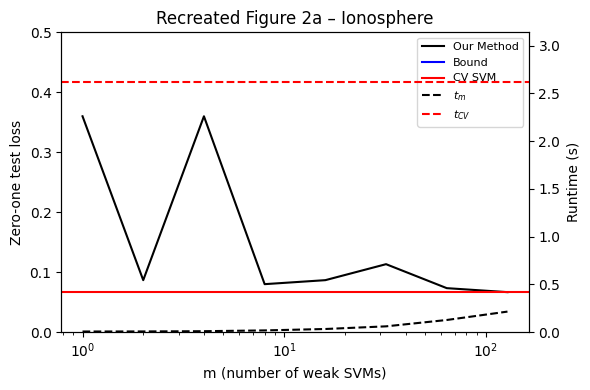

In [1]:
"""
Re-creation of Figure 2a (Ionosphere) from  
“Thiemann, Igel, Wintenberger, Seldin 2017 –
 A Strongly Quasiconvex PAC-Bayesian Bound”.

The script:

1. loads the Ionosphere data set from UCI,
2. builds the strong reference SVM tuned by 5-fold CV,
3. builds a finite hypothesis set of m weak-SVMs
   (each trained on r = d+1 random points),
4. runs the alternating minimisation of the
   PAC-Bayes-λ bound, obtains ρ and λ,
5. evaluates the ρ-weighted majority vote on the
   held-out test set, computes the PAC-Bayes-kl bound,
6. draws Figure 2a.

Only standard scientific-Python packages are used.
"""

import time
import urllib.request
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import zero_one_loss
from scipy.special import logsumexp

# ------------------------------------------------------------------
# 0.  GLOBAL SETTINGS
# ------------------------------------------------------------------
RNG_SEED = 42
np.random.seed(RNG_SEED)

δ = 0.05  # confidence for PAC-Bayes
m_grid = np.array([1, 2, 4, 8, 16, 32, 64, 128])  # x-axis in Fig 2a

# ------------------------------------------------------------------
# 1.  DATA  (download once then keep in memory)
# ------------------------------------------------------------------
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
raw = urllib.request.urlopen(URL).read().decode()
Xy = np.genfromtxt(io.StringIO(raw), delimiter=",", dtype=str)
X_raw = Xy[:, :-1].astype(float)
y_raw = np.where(Xy[:, -1] == "g", 1, -1)  # g → +1, b → –1

scaler = StandardScaler().fit(X_raw)
X_std = scaler.transform(X_raw)

n_total, d = X_std.shape
# fixed split (paper uses |S|=200, |T|=150)
perm = np.random.permutation(n_total)
S_idx = perm[:200]
T_idx = perm[200:350]

X_S, y_S = X_std[S_idx], y_raw[S_idx]
X_T, y_T = X_std[T_idx], y_raw[T_idx]
print(f"Train {X_S.shape},  Test {X_T.shape},  d={d}")


# ------------------------------------------------------------------
# 2.  STRONG CV-SVM  (baseline red horizontal lines)
# ------------------------------------------------------------------
def jaakkola_gamma(X, y):
    G = np.full(len(X), np.inf)
    for i, xi in enumerate(X):
        mask = y != y[i]
        dists = np.linalg.norm(xi - X[mask], axis=1)
        G[i] = dists.min()
    med = np.median(G)
    return 1.0 / (2.0 * med**2)


C_grid = 10.0 ** np.arange(-3, 4)
γ_seed = jaakkola_gamma(X_S, y_S)
γ_grid = γ_seed * 10.0 ** np.array([-4, -2, 0, 2, 4])

param_grid = {"C": C_grid, "gamma": γ_grid}
cv = KFold(n_splits=5, shuffle=True, random_state=RNG_SEED)
grid = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
tic = time.perf_counter()
grid.fit(X_S, y_S)
t_cv = time.perf_counter() - tic

svm_cv = grid.best_estimator_
L_CV = zero_one_loss(y_T, svm_cv.predict(X_T))
print("CV-SVM test loss:", L_CV, " time:", t_cv, "s")

# ------------------------------------------------------------------
# 3.  BUILD H  (weak SVMs)
# ------------------------------------------------------------------
r = d + 1  # 35 for ionosphere
n_val = len(X_S) - r

γ_candidates = γ_grid


def train_weak_svm(train_idx):
    γ = np.random.choice(γ_candidates)
    clf = SVC(kernel="rbf", C=1.0, gamma=γ)
    clf.fit(X_S[train_idx], y_S[train_idx])
    return clf, γ


# ------------------------------------------------------------------
# 4.  PAC-BAYES HELPERS
# ------------------------------------------------------------------
def kl_inv(q, ε, tol=1e-10):
    """Return the smallest p in [q,1] s.t. kl(q||p) ≤ ε (binary search)."""
    if ε <= 0:
        return q
    lo, hi = q, 1.0
    while hi - lo > tol:
        mid = (lo + hi) / 2
        kl = q * np.log(q / mid) + (1 - q) * np.log((1 - q) / (1 - mid))
        if kl > ε:
            lo = mid
        else:
            hi = mid
    return hi


def pac_bayes_kl_bound(A, KL, n):
    """Invert kl to upper-bound the true loss (binary version)."""
    ε = (KL + np.log(2 * np.sqrt(n) / δ)) / n
    return kl_inv(A, ε)


# ------------------------------------------------------------------
# 5.  MAIN LOOP OVER m
# ------------------------------------------------------------------
loss_mv, loss_bound, time_pac = [], [], []

for m in m_grid:
    tic_total = time.perf_counter()

    # 3.1  sample m subsets & train
    weak_clfs, L_val = [], []
    for _ in range(int(m)):
        subset = np.random.choice(len(X_S), size=r, replace=False)
        clf, _ = train_weak_svm(subset)
        weak_clfs.append(clf)
        mask_val = np.setdiff1d(np.arange(len(X_S)), subset, assume_unique=True)
        y_pred = clf.predict(X_S[mask_val])
        L_val.append(zero_one_loss(y_S[mask_val], y_pred))
    L_val = np.array(L_val)

    # 5.1  alternating minimisation
    ρ = np.full(m, 1.0 / m)
    λ = 0.5
    for _ in range(20):
        # ρ-update
        logw = -λ * n_val * L_val + np.log(1.0 / m)
        logw -= logsumexp(logw)
        ρ = np.exp(logw)
        KL = np.sum(ρ * (np.log(ρ) + np.log(m)))  # KL(ρ || uniform)

        # λ-update  (Eq. 8)
        A = np.sum(ρ * L_val)
        B = KL + np.log(2 * np.sqrt(n_val) / δ)
        λ_new = 2.0 / (np.sqrt(2 * n_val * A / B) + 1.0)
        λ_new = np.clip(λ_new, np.sqrt(np.log(2 * np.sqrt(n_val) / δ) / n_val), 1.0)

        if abs(λ - λ_new) < 1e-6:
            λ = λ_new
            break
        λ = λ_new

    # 6.  majority vote on test set
    preds = np.zeros(len(X_T))
    for clf, w in zip(weak_clfs, ρ):
        preds += w * np.sign(clf.predict(X_T))
    y_hat = np.where(preds > 0, 1, -1)
    loss_mv.append(zero_one_loss(y_T, y_hat))

    # 6.2 PAC-Bayes-kl bound on randomised classifier
    A_emp = np.sum(ρ * L_val)
    KL = np.sum(ρ * (np.log(ρ) + np.log(m)))
    loss_bound.append(pac_bayes_kl_bound(A_emp, KL, n_val))

    time_pac.append(time.perf_counter() - tic_total)
    print(f"m={m:4d}  λ={λ:.3f}  test-loss={loss_mv[-1]:.3f}  time={time_pac[-1]:.2f}s")

loss_mv = np.array(loss_mv)
loss_bound = np.array(loss_bound)
time_pac = np.array(time_pac)

# ------------------------------------------------------------------
# 7.  PLOT  (Figure 2a)
# ------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()

ax1.set_xscale("log")
ax1.plot(m_grid, loss_mv, "k-", label="Our Method")
ax1.plot(m_grid, loss_bound, "b-", label="Bound")
ax1.axhline(L_CV, color="red", label="CV SVM")
ax1.set_xlabel("m (number of weak SVMs)")
ax1.set_ylabel("Zero-one test loss")
ax1.set_ylim(0, 0.5)

ax2.plot(m_grid, time_pac, "k--", label=r"$t_m$")
ax2.axhline(t_cv, color="red", linestyle="--", label=r"$t_{CV}$")
ax2.set_ylabel("Runtime (s)")
ax2.set_ylim(0, max(time_pac.max(), t_cv) * 1.2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=8)

plt.title("Recreated Figure 2a – Ionosphere")
plt.tight_layout()
plt.show()